# Séries Temporelles


Importons les bibliothèques nécécessaires

In [93]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 
from pandas.plotting import register_matplotlib_converters

In [94]:
register_matplotlib_converters()

importons le jeu de données

In [95]:
#import du le dataset
crimes = pd.read_csv(r'C:\Users\gaman\OneDrive - baudoin\Bureau\serie temporelle\BPD_Part_1_Victim_Based_Crime_Data.csv')

In [96]:
crimes.head(-5)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Total Incidents
0,11/12/2016,02:35:00,3B,300 SAINT PAUL PL,ROBBERY - STREET,O,NaN,111.0,CENTRAL,Downtown,"(39.2924100000, -76.6140800000)",1
1,11/12/2016,02:56:00,3CF,800 S BROADWAY,ROBBERY - COMMERCIAL,I,FIREARM,213.0,SOUTHEASTERN,Fells Point,"(39.2824200000, -76.5928800000)",1
2,11/12/2016,03:00:00,6D,1500 PENTWOOD RD,LARCENY FROM AUTO,O,NaN,413.0,NORTHEASTERN,Stonewood-Pentwood-Winston,"(39.3480500000, -76.5883400000)",1
3,11/12/2016,03:00:00,6D,6600 MILTON LN,LARCENY FROM AUTO,O,NaN,424.0,NORTHEASTERN,Westfield,"(39.3626300000, -76.5516100000)",1
4,11/12/2016,03:00:00,6E,300 W BALTIMORE ST,LARCENY,O,NaN,111.0,CENTRAL,Downtown,"(39.2893800000, -76.6197100000)",1
...,...,...,...,...,...,...,...,...,...,...,...,...
285797,01/01/2011,22:00:00,6D,200 EMORY ST,LARCENY FROM AUTO,O,NaN,941.0,SOUTHERN,Ridgely's Delight,"(39.2861000000, -76.6247400000)",1
285798,01/01/2011,22:00:00,6D,1200 N CALHOUN ST,LARCENY FROM AUTO,O,NaN,743.0,WESTERN,Sandtown-Winchester,"(39.3025800000, -76.6403600000)",1
285799,01/01/2011,22:00:00,4E,2700 ASHLAND AV,COMMON ASSAULT,O,HANDS,323.0,EASTERN,Madison-Eastend,"(39.3010900000, -76.5788000000)",1
285800,01/01/2011,22:00:00,5A,2300 BOSTON ST,BURGLARY,I,NaN,232.0,SOUTHEASTERN,Canton,"(39.2828600000, -76.5842000000)",1


filtrons notre dataset

In [97]:
crime2 = crimes[["CrimeDate", "CrimeTime", "Total Incidents"]]
crime2.head()

,CrimeDate,CrimeTime,Total Incidents
0,11/12/2016,02:35:00,1
1,11/12/2016,02:56:00,1
2,11/12/2016,03:00:00,1
3,11/12/2016,03:00:00,1
4,11/12/2016,03:00:00,1


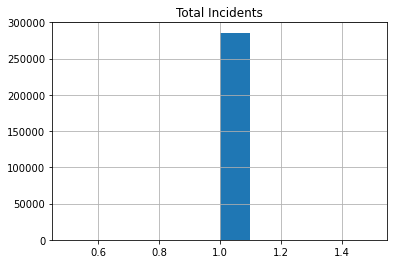

In [98]:
crime2.hist(column='Total Incidents', bins=10);

Regroupons les crimes par date

In [99]:
crime_date = crime2.groupby(['CrimeDate']).sum()
crime_date.head(-5)


,Total Incidents
CrimeDate,
01/01/2011,185
01/01/2012,176
01/01/2013,157
01/01/2014,139
01/01/2015,157
...,...
12/30/2011,130
12/30/2012,116
12/30/2013,121


<function matplotlib.pyplot.show(close=None, block=None)>

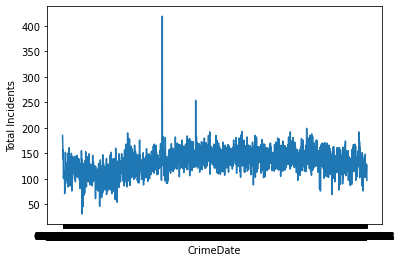

In [100]:
# Visualisons le nombres d'incident par date
plt.xlabel('CrimeDate')
plt.ylabel('Total Incidents')
plt.plot(crime_date)
plt.show

Groupons les crimes par heures 

In [101]:
crime_heure = crime2.groupby(['CrimeTime']).sum()
crime_heure.head(-5)

,Total Incidents
CrimeTime,
0000,2
0001,2
0002,7
0003,9
0004,4
...,...
23:56:00,67
23:56:18,1
23:57:00,63


<function matplotlib.pyplot.show(close=None, block=None)>

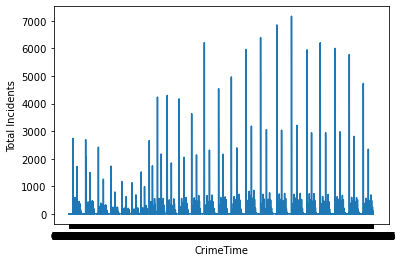

In [102]:
# Visualisons le nombre d'incident par Heure
plt.xlabel('CrimeTime')
plt.ylabel('Total Incidents')
plt.plot(crime_heure)
plt.show

# Statistiques Roulantes

In [103]:
crimes.describe(include='all')

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Location 1,Total Incidents
count,285807,285807,285807,284184,285807,281611,97396,285616.000000,285749,284106,284188,285807.0
unique,2143,4236,81,25949,15,4,4,NaN,13,280,97951,NaN
top,04/27/2015,18:00:00,4E,200 E PRATT ST,LARCENY,I,HANDS,NaN,NORTHEASTERN,Downtown,"(39.3180000000, -76.6582100000)",NaN
freq,419,7167,47881,676,62623,141858,51691,NaN,44832,9666,651,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,504.234184,NaN,NaN,NaN,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.354783,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.000000,NaN,NaN,NaN,1.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445.000000,NaN,NaN,NaN,1.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,723.000000,NaN,NaN,NaN,1.0


In [104]:
#calculons la moyenne roulante pour notre crimes
rolling_mean = crimes.rolling(window= 12).mean()
print(rolling_mean)

              Post  Total Incidents
0              NaN              NaN
1              NaN              NaN
2              NaN              NaN
3              NaN              NaN
4              NaN              NaN
...            ...              ...
285802  499.750000              1.0
285803  442.166667              1.0
285804  483.000000              1.0
285805  514.000000              1.0
285806  445.750000              1.0

[285807 rows x 2 columns]
